This is the first of two projects for DATA201. It is due at the end of the first half of the trimester, i.e., Friday 12th April, before midnight. 

As with the assignments, please submit only this single jupyter notebook with your code added into it at the appropriate places to http://apps.ecs.vuw.ac.nz/submit/DATA201.

There are two tasks in this project. The first is fairly freeform. The second is more guided, but a bit harder. Not everybody will finish the second one. The two datasets are available on the course webpage.

To get a reasonable grade on this project you should attempt both questions, and do a good job on task 1. Making the PCA work on the shape of the hands as well is what will get you an excellent grade.

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
import math
import re
import matplotlib.dates as mdates
from datetime import datetime
%matplotlib inline

Task 1: Fisheries Bycatch
===

In [6]:
df = pd.read_csv('http://sms.victoria.ac.nz/foswiki/pub/Courses/DATA201_2019T1/WebHome/protected_species_captures.csv')
df.head()

,fishing_year,datetime,taxon,status,identification,capture_method,method,target,vessel_size,area,version,latitude,longitude,mitigation_equipment,excluded
0,2002/2003,2002-09-30 21:45:00+00:00,sooty shearwater,dead,necropsy,net,trawl,Hoki,43+,Fiordland,v20180001,166.055313,-46.704290,NaN,NaN
1,2002/2003,2002-09-30 21:45:00+00:00,sooty shearwater,dead,necropsy,net,trawl,Hoki,43+,Fiordland,v20180001,166.025787,-46.696851,NaN,NaN
2,2002/2003,2002-09-30 21:45:00+00:00,sooty shearwater,dead,necropsy,net,trawl,Hoki,43+,Fiordland,v20180001,166.032242,-46.708154,NaN,NaN
3,2002/2003,2002-09-30 21:45:00+00:00,sooty shearwater,dead,necropsy,net,trawl,Hoki,43+,Fiordland,v20180001,166.057565,-46.683379,NaN,NaN
4,2002/2003,2002-09-30 21:45:00+00:00,white-chinned petrel,dead,necropsy,net,trawl,Hoki,43+,Fiordland,v20180001,166.057377,-46.685194,NaN,NaN


In [7]:
df.tail()

,fishing_year,datetime,taxon,status,identification,capture_method,method,target,vessel_size,area,version,latitude,longitude,mitigation_equipment,excluded
12656,2016/2017,2017-09-26 18:20:00+00:00,Buller's shearwater,alive,observer,deck,trawl,Trevally,17-28,West Coast North Island,v20180001,172.923840,-34.413029,none,deck
12657,2016/2017,2017-09-26 18:20:00+00:00,Buller's shearwater,alive,observer,deck,trawl,Trevally,17-28,West Coast North Island,v20180001,172.895511,-34.377766,none,deck
12658,2016/2017,2017-09-26 18:20:00+00:00,Cook's Petrel,alive,imputation,deck,trawl,Trevally,17-28,West Coast North Island,v20180001,172.919118,-34.375103,none,deck
12659,2016/2017,2017-09-26 18:20:00+00:00,Buller's shearwater,alive,observer,deck,trawl,Trevally,17-28,West Coast North Island,v20180001,172.922471,-34.386383,none,deck
12660,2016/2017,2017-09-26 18:20:00+00:00,Buller's shearwater,alive,imputation,deck,trawl,Trevally,17-28,West Coast North Island,v20180001,172.898423,-34.408640,none,deck


In [8]:
# Data Cleansing
#     to calculate and compare the alive rate among different locations, method, target fish, and so on,
# the rows whose "status" column are "NaN" need to be removed temporarily.
#print(df.loc[8600:8700])
df = df.dropna(subset = ["status"])
df = df.reset_index(drop = True)
#df = df.dropna(subset = ["excluded"])
#print(df.loc[8600:8700,3:4])
df.tail()

,fishing_year,datetime,taxon,status,identification,capture_method,method,target,vessel_size,area,version,latitude,longitude,mitigation_equipment,excluded
12623,2016/2017,2017-09-26 18:20:00+00:00,Buller's shearwater,alive,observer,deck,trawl,Trevally,17-28,West Coast North Island,v20180001,172.923840,-34.413029,none,deck
12624,2016/2017,2017-09-26 18:20:00+00:00,Buller's shearwater,alive,observer,deck,trawl,Trevally,17-28,West Coast North Island,v20180001,172.895511,-34.377766,none,deck
12625,2016/2017,2017-09-26 18:20:00+00:00,Cook's Petrel,alive,imputation,deck,trawl,Trevally,17-28,West Coast North Island,v20180001,172.919118,-34.375103,none,deck
12626,2016/2017,2017-09-26 18:20:00+00:00,Buller's shearwater,alive,observer,deck,trawl,Trevally,17-28,West Coast North Island,v20180001,172.922471,-34.386383,none,deck
12627,2016/2017,2017-09-26 18:20:00+00:00,Buller's shearwater,alive,imputation,deck,trawl,Trevally,17-28,West Coast North Island,v20180001,172.898423,-34.408640,none,deck


Carry out some exploratory data analysis on this dataset. You might want to consider things like: 
* how many different species were killed?
* which is the worst fisheries location for bycatch?
* which is the worst type of fishery (by method or target fish)?
* is the problem getting better or worse?
* does the mitigation equipment work?

In [5]:
# how many different species were killed?

In [9]:
# taxon: a taxonomic group of any rank, 
#        such as a species, family, or class.
df_taxon = df[["taxon", "status"]]
#print(df_taxon.head())
#print("status: ", df.status.unique())
df_taxon_killed = df_taxon[df_taxon.status == "killed"]
#print(df_taxon_killed.head())
print("There are", df_taxon_killed.taxon.nunique(), "different species were killed.")
print("They are: ")
for species in df_taxon_killed.taxon.unique():
    print("    ", species)

There are 7 different species were killed.
They are: 
     giant petrels
     Cape petrel
     fairy prion
     southern royal albatross
     southern Buller's albatross
     New Zealand white-capped albatross
     New Zealand fur seal


In [7]:
# which is the worst fisheries location for bycatch?

In [10]:
df_area = df[["area", "status", "version"]]
df_pivot_area_status = pd.pivot_table(df_area, index = "area", columns = "status", values  = "version", aggfunc = "count")
print(df_pivot_area_status)
print()

df_alive_rate_byArea = pd.DataFrame(columns = ["Alive Rate"])
for i, row in df_pivot_area_status.iterrows():
    count_alive = row["alive"]
    # count_all counts the total number of caese recorded for a certain area
    count_all   = df.groupby("area").count()["version"][i]
    alive_rate  = count_alive / count_all
    df_alive_rate_byArea.loc[i]={"Alive Rate": alive_rate}
print(df_alive_rate_byArea)
print()

worst_location = df_alive_rate_byArea["Alive Rate"].idxmin()
lowest_alive_rate = df_alive_rate_byArea["Alive Rate"].loc[worst_location]
print("The worst fisheries location for bycatch is: " + worst_location 
      + ", whose alive rate is the lowest: " + str(lowest_alive_rate * 100) + "%.")

status                    alive    dead  decomposed  killed
area                                                       
Auckland Islands          628.0  1123.0        33.0     NaN
Bay of Plenty             177.0    92.0         NaN     NaN
Chatham Rise              231.0   528.0         6.0     3.0
Cook Strait                74.0   258.0         NaN     NaN
East Coast North Island   109.0   182.0         2.0     NaN
East Coast South Island   347.0   678.0        12.0     NaN
Fiordland                 496.0   409.0         2.0     NaN
Kermadec Islands           21.0    59.0         1.0     NaN
Northland and Hauraki     252.0   209.0         NaN     NaN
Stewart Snares Shelf     1722.0  2198.0        23.0     1.0
Subantarctic              272.0   807.0        11.0     3.0
Taranaki                   79.0   204.0         2.0     1.0
West Coast North Island   127.0   118.0         NaN     NaN
West Coast South Island   330.0   784.0        13.0     1.0

                         Alive Rate
Auc

In [8]:
# which is the worst type of fishery (by method or target fish)?

In [11]:
df_method = df[["method", "status", "version"]]
df_pivot_method_status = pd.pivot_table(df_method, index = "method", columns = "status", values  = "version", aggfunc = "count")
print(df_pivot_method_status)
print()

df_alive_rate_byMethod = pd.DataFrame(columns = ["Alive Rate"])
for i, row in df_pivot_method_status.iterrows():
    count_alive = row["alive"]
    # count_all counts the total number of caese recorded for a certain method
    count_all   = df.groupby("method").count()["version"][i]
    alive_rate  = count_alive / count_all
    df_alive_rate_byMethod.loc[i]={"Alive Rate": alive_rate}
print(df_alive_rate_byMethod)
print()

worst_method = df_alive_rate_byMethod["Alive Rate"].idxmin()
lowest_alive_rate = df_alive_rate_byMethod["Alive Rate"].loc[worst_method]
print("The worst fisheries method for bycatch is: " + worst_method 
      + ", whose alive rate is the lowest: " + str(lowest_alive_rate * 100) + "%.")

status             alive    dead  decomposed  killed
method                                              
bottom longline    775.0   739.0        13.0     4.0
purse seine         92.0     7.0         NaN     NaN
setnet              74.0   113.0         3.0     NaN
surface longline   716.0   826.0         6.0     NaN
trawl             3208.0  5964.0        83.0     5.0

                  Alive Rate
bottom longline     0.506205
purse seine         0.929293
setnet              0.389474
surface longline    0.462532
trawl               0.346436

The worst fisheries method for bycatch is: trawl, whose alive rate is the lowest: 34.64362850971922%.


In [12]:
df_target = df[["target", "status", "version"]]
df_pivot_target_status = pd.pivot_table(df_target, index = "target", columns = "status", values  = "version", aggfunc = "count")
print(df_pivot_target_status)
print()

df_alive_rate_byTarget = pd.DataFrame(columns = ["Alive Rate"])
for i, row in df_pivot_target_status.iterrows():
    count_alive = row["alive"]
    if math.isnan(count_alive):
        count_alive = 0
    # count_all counts the total number of caese recorded for a certain method
    count_all   = df.groupby("target").count()["version"][i]
    alive_rate  = count_alive / count_all
    df_alive_rate_byTarget.loc[i]={"Alive Rate": alive_rate}
df_alive_rate_byTarget = df_alive_rate_byTarget.sort_values(by = "Alive Rate")
print(df_alive_rate_byTarget)
print()

worst_target_list    = df_alive_rate_byTarget[df_alive_rate_byTarget["Alive Rate"] == 0].index
worst_targets_string = ""
for worst_target in list(worst_target_list):
    worst_targets_string += str(worst_target)
    worst_targets_string += ", "
print("The worst fisheries target for bycatch are: " + worst_targets_string + "whose alive rates are all 0%.")

status                          alive    dead  decomposed  killed
target                                                           
Albacore tuna                     2.0    72.0         NaN     NaN
Alfonsino & long-finned beryx     5.0     4.0         NaN     NaN
Arrow squid                    1436.0  2548.0        45.0     1.0
Barracouta                       94.0   261.0         NaN     NaN
Bass groper                       1.0     NaN         NaN     NaN
Bigeye tuna                      43.0    79.0         NaN     NaN
Black oreo                       10.0     5.0         NaN     NaN
Blue cod                          NaN     4.0         NaN     NaN
Blue mackerel                     5.0     4.0         NaN     NaN
Bluenose                         53.0     9.0         NaN     NaN
Broadbill swordfish              45.0    72.0         1.0     NaN
Butterfish                        2.0    16.0         NaN     NaN
Common warehou                   19.0    45.0         3.0     NaN
Elephant f

In [63]:
# is the problem getting better or worse?

In [13]:
df_year = df[["fishing_year", "status", "version"]]
df_pivot_year_status = pd.pivot_table(df_year, index = "fishing_year", columns = "status", values  = "version", aggfunc = "count")
print(df_pivot_year_status)
print()

df_alive_rate_byYear = pd.DataFrame(columns = ["Alive Rate"])
for i, row in df_pivot_year_status.iterrows():
    count_alive = row["alive"]
    # count_all counts the total number of caese recorded for a certain method
    count_all   = df.groupby("fishing_year").count()["version"][i]
    alive_rate  = count_alive / count_all
    df_alive_rate_byYear.loc[i]={"Alive Rate": alive_rate}
print(df_alive_rate_byYear)
print()

status        alive   dead  decomposed  killed
fishing_year                                  
2002/2003     383.0  632.0         1.0     3.0
2003/2004     172.0  447.0         5.0     1.0
2004/2005     317.0  652.0         8.0     1.0
2005/2006     185.0  498.0         3.0     NaN
2006/2007     155.0  466.0         6.0     1.0
2007/2008     186.0  402.0        11.0     NaN
2008/2009     255.0  524.0        10.0     NaN
2009/2010     430.0  389.0         5.0     NaN
2010/2011     255.0  384.0        15.0     NaN
2011/2012     214.0  327.0         1.0     NaN
2012/2013     465.0  619.0        12.0     1.0
2013/2014     396.0  620.0         7.0     2.0
2014/2015     490.0  518.0         3.0     NaN
2015/2016     579.0  680.0         7.0     NaN
2016/2017     383.0  491.0        11.0     NaN

           Alive Rate
2002/2003    0.375859
2003/2004    0.275200
2004/2005    0.324131
2005/2006    0.269679
2006/2007    0.246815
2007/2008    0.310518
2008/2009    0.323194
2009/2010    0.521845
20

In [20]:
df_year_month = df[["datetime", "status", "version"]]
# in datatime format
df_year_month.loc[:,"date_time"] = df_year_month["datetime"].apply(lambda x : datetime.strptime(x.split("+")[0], '%Y-%m-%d %H:%M:%S'))
# year in datatime format
df_year_month.loc[:,"year"]  = df_year_month["date_time"].apply(lambda x : x.year)
df_year_month.loc[:,"month"] = df_year_month["date_time"].apply(lambda x : x.month)
df_year_month.drop(['datetime'],  axis = 1, inplace = True)
df_year_month.drop(['date_time'], axis = 1, inplace = True)
df_year_month.loc[:,"year-month"] = df_year_month.apply(lambda row : str(row["year"]) + "-" + str(row["month"]), axis = 1)
# string -> datetime
df_year_month.loc[:,"year-month"] = df_year_month["year-month"].apply(lambda x : datetime.strptime(x, '%Y-%m'))
#print(df_year_month)

df_pivot_year_month_status = pd.pivot_table(df_year_month, index = "year-month", columns = "status", values  = "version", aggfunc = "count")
#print(df_pivot_year_month_status)
#print()

df_alive_rate_byYearMonth = pd.DataFrame(columns = ["Alive Rate"])
for i, row in df_pivot_year_month_status.iterrows():
    count_alive = row["alive"]
    # count_all counts the total number of caese recorded for a certain method
    count_all   = df_year_month.groupby("year-month").count()["version"][i]
    alive_rate  = count_alive / count_all
    if math.isnan(alive_rate) == True:
        alive_rate = 0
    #year = df_pivot_year_month_status.index[i]
    df_alive_rate_byYearMonth.loc[i]={"Alive Rate": alive_rate}
print(df_alive_rate_byYearMonth.head())
print()

           Alive Rate
2002-09-01          0
2002-10-01   0.754967
2002-11-01   0.239437
2002-12-01   0.333333
2003-01-01  0.0333333



In [21]:
# to prepare tuples for box-chart plotting
alive_rate_list = []
year_list = []
for y in range(2002, 2018):  
    df_each_year_month = df_alive_rate_byYearMonth[df_alive_rate_byYearMonth.index.year == y] 
    alive_rate_list.append(tuple(df_each_year_month["Alive Rate"]))
    year_list.append(y)    
alive_rate_tuple = tuple(alive_rate_list)
year_tuple = tuple(year_list)

In [42]:
# Description: 
#          to return the linearly fitted log(count) 
# Input:   Date column in DataFrame (in Datetime dtype)
#          Count column in DataFrame
# Output:  Linearly fitted log(count)
# e.g.:    linear_fit_log_count(df_HBR.Date, df_HBR.Count)
#          linear_fit_log_count(df_STP.Date, df_STP.Count)

def linear_fit_rate(date, rate):
    x_num    = mdates.date2num(date)       # Datetime dtype -> int because np.polyfit() doesn't take Datetime
    y        = rate.values

    
    
    for each in range(y.size):
        y[each] = np.float64(y[each])
        #print(type(y[each]))
        if y[each] == 0:
            y[each] = 0.01
            
    for each in range(x_num.size):
        print(type(x_num[each]))
    for each in range(y.size):
        print(type(y[each]))

        
    print(y)
    m, b     = np.polyfit(x_num, y, 1) 
    y_fit    = m * x_num + b
    return y_fit

In [57]:
# test
xxx    = mdates.date2num(df_alive_rate_byYearMonth.index)[2:]       # Datetime dtype -> int because np.polyfit() doesn't take Datetime
yyy        = df_alive_rate_byYearMonth["Alive Rate"].values[2:]
m, b     = np.polyfit(xxx, yyy, 5) 
pl.plot(x_num, y)

TypeError: No loop matching the specified signature and casting
was found for ufunc lstsq_n

<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.fl

TypeError: No loop matching the specified signature and casting
was found for ufunc lstsq_n

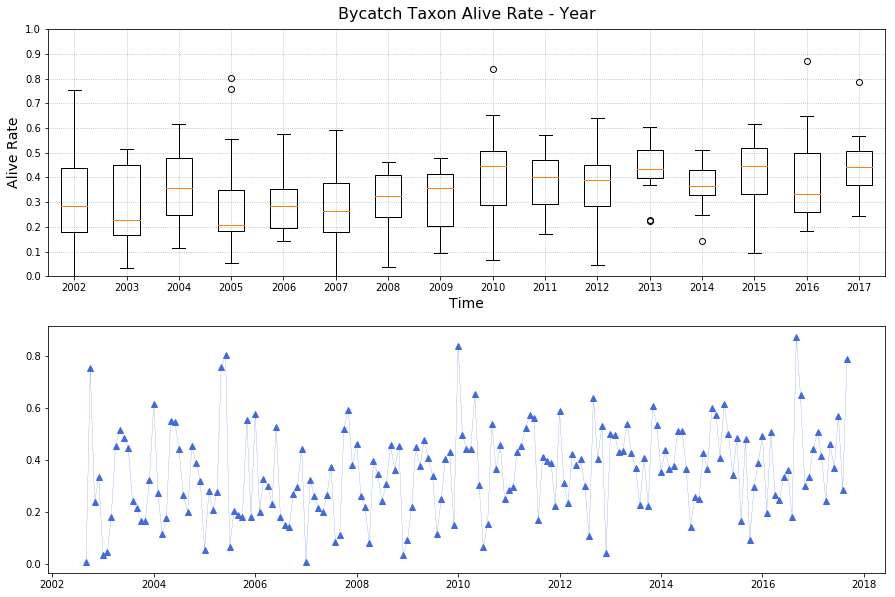

In [43]:
fig, ax = pl.subplots(2, 1, figsize = (15, 10))             # create a new figure & set the figure size
ax[0].boxplot(alive_rate_tuple, labels = year_tuple) 
ax[0].set_xlabel('Time', fontsize = 14) 
ax[0].set_ylabel('Alive Rate', fontsize = 14) 
ax[0].set_title('Bycatch Taxon Alive Rate - Year', fontsize = 16, pad = 10)     # pad: offset of the title from the top of the axes
ax[0].set_ylim(0, 1)
ax[0].set_yticks(np.arange(0, 1.1, 0.1))
ax[0].xaxis.grid(which = "both", linestyle = ":")
ax[0].yaxis.grid(which = "both", linestyle = ":")


ax[1].plot(df_alive_rate_byYearMonth.index, df_alive_rate_byYearMonth["Alive Rate"], linewidth = 0.2, color='royalblue', marker='^', linestyle='solid')  
ax[1].plot(df_alive_rate_byYearMonth.index, linear_fit_rate(df_alive_rate_byYearMonth.index, df_alive_rate_byYearMonth["Alive Rate"]), 
           linewidth = 1, color='royalblue', linestyle='solid') 
ax[1].set_xlabel('Time', fontsize = 14) 
ax[1].set_ylabel('EColi count', fontsize = 14) 
ax[1].set_title('Bycatch Taxon Alive Rate - Month', fontsize = 16, pad = 10)     # pad: offset of the title from the top of the axes
ax[1].set_yticks(np.arange(0, 1.1, 0.1))
ax[1].xaxis.grid(which = "both", linestyle = ":")
ax[1].yaxis.grid(which = "both", linestyle = ":")

pl.subplots_adjust(hspace = 0.3)                           # adjust the space between the 2 subplots
pl.show()

In [265]:



# print("identification:")
# print(df.identification.unique())
# print("capture_method:")
# print(df.capture_method.unique())
# print("method:")
# print(df.method.unique())
# print("target:")
# print(df.target.unique())
# print("vessel_size:")
# print(df.vessel_size.unique())
# print("area:")
# print(df.area.unique())
# print("mitigation_equipment:")
# print(df.mitigation_equipment.unique())
# print("excluded:")
# print(df.excluded.unique())

In [267]:
# does the mitigation equipment work?

Earlier versions of this kind of data lead to the Ministry of Primary Industries taking bycatch seriously. Briefly discuss how this data could best be used, and what, if any, ethical implications there are for it.

Task 2: Hand Shapes
===

In this task you are going to see an interesting thing that you can do with PCA, namely deform shapes. We describe each shape with a set of landmark points, and then look at how each landmark varies in its position across the dataset. 
There are 40 images of hands from 4 people, with 56 landmarks in 2D on each. The first 56 points in each line are the x coordinates, and the next 56 are the y coordinates. The data is in hands.txt on the course webpage.

In [268]:
# Load the data
points = np.loadtxt('/home/marslast/Dropbox/Transfer/Teaching/DATA201/Datasets/hands/shapes/hands.txt',delimiter=' ')

OSError: /home/marslast/Dropbox/Transfer/Teaching/DATA201/Datasets/hands/shapes/hands.txt not found.

Now plot a couple of the hands to see what they look like. The $x$ coordinates are the first 56 numbers, and the $y$ coordinates the next 56, so you can plot points[:56,0] and points[56:,0]

Plot the points for all the hands, so that you can see what a mess it is. You will need to write a loop over the rows of points to plot them all.

Plot the first hand on top (with a line between the points) to see if you can see any structure.

Now use the standardisation from scikit-learn to transform the data and plot it again. You will see that it hasn't made things better. 

Aligning shape data is a bit harder. The way to perform the alignment is called Procrustes alignment. This name comes from Greek mythology. Procrustes was an innkeeper, who claimed the beds in his hotel were the perfect size for everybody. However, to make this true, he changed the person to fit the bed, not the bed to fit the person, stretching them or chopping bits off as necessary. Procrustes alignment does the same thing, without the brutality. 

It does this by rotating, translating, and scaling each set of points so that they are as close as possible to one that we choose as the reference set (the first, for simplicity). We implement this by following a set of steps:

(1) For each hand, move it so that the centroid (middle point) is at the origin by subtracting off the mean in x and y separately. In other words, compute the mean of the x coordinates of each shape, and subtract that from all of them, and the same in y. 
I've made you a new array called newpoints to put the data into. The command to compute the mean is np.mean. It's syntax is np.mean(A,axis=0), which computes the mean of each column of matrix A.

In [ ]:
newpoints = np.zeros(np.shape(points))

(2) Scale each hand so that the root mean square distance from the points to the origin is 1. So compute the scale factor as $s = 1/k * \sqrt{(x_1 - \bar{x})^2 + (y_1 - \bar{y})^2 + \ldots + (y_k - \bar{y})^2}$ where there are $k$ points in each hand (so $k=56$). np.sum will help you do the addition. Then divide each of the points by this scale factor.

(3) Now rotate each hand from 1 to 40 so that it best lines up with hand 0. This is harder than the others, so I've done it for you. 

In [ ]:
for i in range(1,40):
    a = np.sum(newpoints[:,i]* newpoints[:,0])
    b = np.sum(newpoints[:56,i]*newpoints[56:,0] - newpoints[:56,0]*newpoints[56:,i])
    theta = np.arctan2(b , max(a, 10**-10))
    for j in range(56):
        point = np.array([newpoints[j,i],newpoints[j+56,i]])
        x = np.dot(np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]]), point)
        newpoints[j,i] = x[0]
        newpoints[j+56,i] = x[1]

Now plot the data again. It's better, but the hand isn't properly lined up yet. 

We can make things better, by replacing the points data with newpoints, replacing the first datapoint with the mean, and then running the translation, rotation and scaling again. Run the code below, and then the previous three bits of code again. This time, the plot should look a bit more convincing.

In [ ]:
points = newpoints
meanshape = np.mean(newpoints,axis=1)
points[:,0]=meanshape

Below is my code to do PCA. Run it. 

In [ ]:
# Compute the covariance matrix
C = np.cov(newpoints)

# Get the eigenvalues and eigenvectors
evals,evecs = np.linalg.eig(C)

# Now need to sort them into descending order
indices = np.argsort(evals)
indices = indices[::-1]
evecs = evecs[:,indices]
evals = evals[indices]
evecs = np.real(evecs)
evals = np.real(evals)

Plot the mean shape (i.e., the shape you get when you just compute the mean of each datapoint across the whole dataset), and also the mean shape plus and minus a small amount in each of the first few PCs (one at a time). See if you can work out what each of them does.

Decide how many principal components you should use by plotting the cumulative sum of the eigenvalues. Explain your answer.